In [1]:
import math
import sys
sys.path.append('../darknight/')
from utils import array_in_nd_array, remove_space, r2pcorr,struc2mol
import numpy as np
import pandas as pd
import darkchem
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.linear_model import LinearRegression
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools,Draw
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [2]:
#load model
model = darkchem.utils.load_model('../Final Trained DarkChem Network Weights/N7b_[M+H]')

In [3]:
data = pd.read_csv('multiple_0.9.csv')

In [4]:
data.head()

,Index,Reactants,Products
0,2,CCCCCC/C=C/C(=O)O,CCCCCC/C=C/CO
1,3,c1ccc2c(c1)CCCC2,c1ccc2ccccc2c1
2,4,CC=CCCCCCCCCCC(=O)O,CCCCCCCCCCC=CC(=O)O
3,5,COC1=CC=CC=CC1,COC1C=CC=CC=C1
4,7,CCCCCc1ccc(O)cc1,CCCCCC1CCC(O)CC1


In [5]:
len(data)

1817

In [6]:
# calculate the vectors of reactants and products
rvec = [darkchem.utils.struct2vec(reactant) for reactant in data['Reactants']]
pvec = [darkchem.utils.struct2vec(product) for product in data['Products']]
# transform the data type to np.array 
# for the calculation of latent space vectors
rvec = np.array(rvec).astype(int)
pvec = np.array(pvec).astype(int)

In [7]:
#generate the latent space representation for reactants and products
r_latent = model.encoder.predict(rvec)
p_latent = model.encoder.predict(pvec)

In [8]:
# transform the data type to DataFrame for the computing of Pearson Correlation
rvecdf = pd.DataFrame(r_latent)
pvecdf = pd.DataFrame(p_latent)

In [9]:
# calculate the correlation between the latent reactant vectors to product vectors
r2p = r2pcorr(rvecdf,pvecdf)
#r2p

In [10]:
# the average value of correlation
r2p.mean()

Correlation    0.942512
dtype: float64

In [11]:
#load regression analysis set
x = rvecdf.iloc[:,0:128].values
y = pvecdf.iloc[:,0:128].values

In [12]:
# split the training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = .2, random_state=1234)

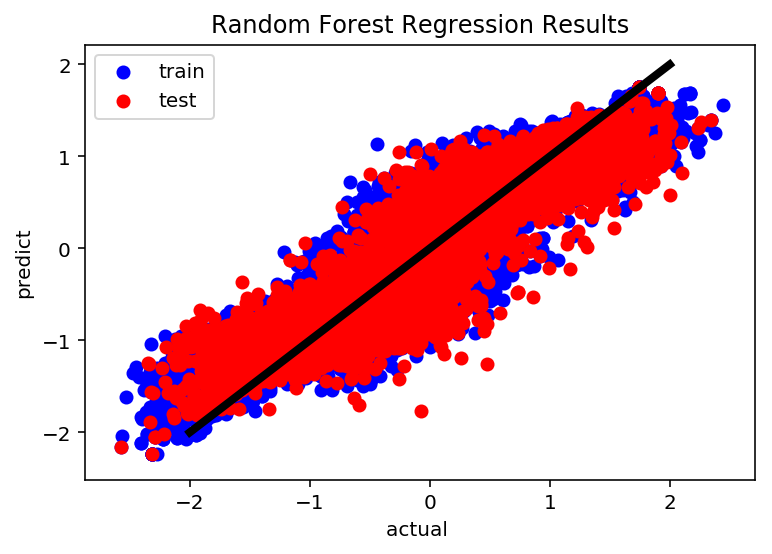

In [13]:
# Fitting the Regression model to the dataset

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 300, random_state = 123, min_samples_split=15)
regressor.fit(X_train,Y_train)

# Predicting a new result with the Random Forest Regression

Ytrain_Pred = regressor.predict(X_train)
Ytest_Pred = regressor.predict(X_test)

# Visualising the Random Forest Regression results in higher resolution and smoother curve
#X_Grid = np.arange(min(X), max(X), 0.01)
#X_Grid = X_Grid.reshape((len(X_Grid), 1))
plt.scatter(Y_train,Ytrain_Pred, color = 'blue',label = 'train')
plt.scatter(Y_test,Ytest_Pred, color = 'red',label = 'test')
#plt.plot(X_Grid, regressor.predict(X_Grid), color = 'black')
plt.plot([-2,2],[-2,2],lw=4,color='black')
plt.title('Random Forest Regression Results')
plt.xlabel('actual ')
plt.ylabel('predict')
plt.legend(loc = 'best')
plt.show()

In [14]:
regressor.score(X_test,Y_test)

0.48916081985757104

In [15]:
# predict the prodcut of Aceton
smi = 'O=C(O)Cc1ccccc1' 

In [16]:
#transform smiles string to structure vector
test = darkchem.utils.struct2vec(smi)

In [17]:
# shape the test list
test = np.array(test)
test = test.reshape(-1,100)

In [18]:
# generate the latent space vectors of Aceton
t_l = model.encoder.predict(test)

In [19]:
# predict the latent sapce vector of Aceton product using Aceton latent vector
t_pre = regressor.predict(t_l.reshape(1,-1))

In [20]:
#transform product latent space vector to structure vector
t_pred = model.decoder.predict(t_pre)

In [21]:
#search and match the specific prodcuts with the predicted structure vector
trs = darkchem.utils.beamsearch(t_pred, k=10)
# because k = 10, so there will be 10 results, you can change the value of k to get the amount of predicted products.

In [22]:
# shaping
trs = trs.flatten()
trs = trs.reshape(-1,100)

In [23]:
# transform structure vectors to smiles strings
v2s = [darkchem.utils.vec2struct(trs[i]) for i in range(len(trs))]

In [24]:
# transform Dict to DataFrame
sms = {'smiles': v2s}
sms = pd.DataFrame(data = sms)
sms

,smiles
0,O=C(N)CC1CCCCC1
1,O=C(O)CC1CCCC
2,O=C(O)CCNCCCCC
3,O=C(OCCC1CCCCC
4,O=C(O)CC1CCNCC1
5,O=C(O)CC1CCCC
6,O=C(N)CC1CCCCC
7,O=C(O)CC1CCNCC
8,O=C(O)CC1CCCCC1
9,O=C(O)CC1CCCCC


In [25]:
#transform smiles strings to molecule structures
df = struc2mol(sms)

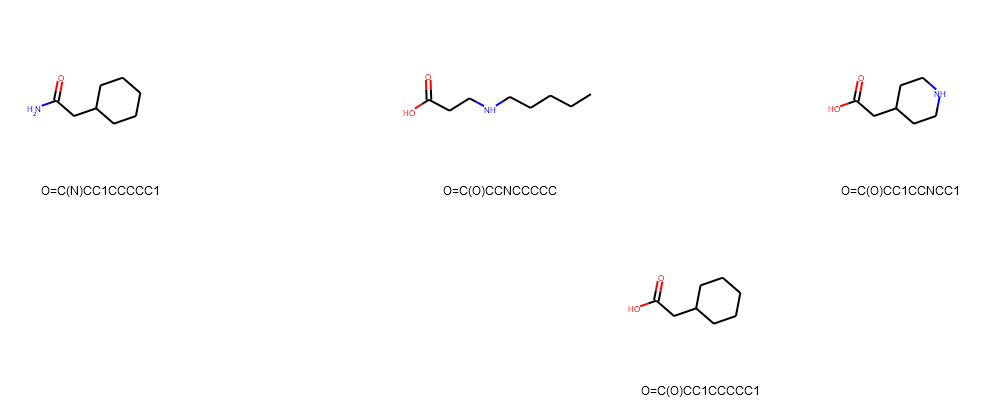

In [26]:
# display the products smiles strings with their molecule structures
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=5))
# contain invalid molecules from the prediction result

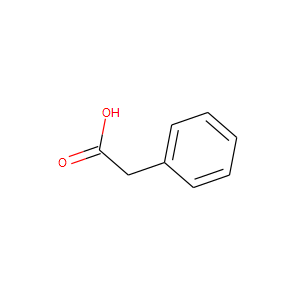

In [27]:
# the molecule structure of reactant
mol = Chem.MolFromSmiles('O=C(O)Cc1ccccc1')
Draw.MolToImage(mol)

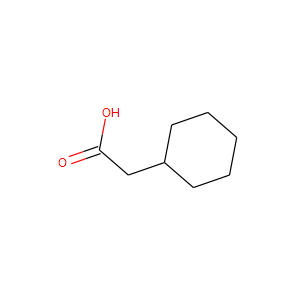

In [28]:
# the actual molecule structure of product
mol = Chem.MolFromSmiles('O=C(O)CC1CCCCC1')
Draw.MolToImage(mol)

In [29]:
#C=CC=C.Cc1ccc(C)cc1 	C=CC(C)Cc1ccc(C)cc1 # a little better
#"C=CC=O.CC(CO)CO 	C=CC1OCC(C)CO1" #bad
#CC(=O)c1ccccc1 to CCC(=O)c1ccccc1 #bad
#c1ccc(C2CO2)cc1	CC(O)c1ccccc1 # good
#O=C(O)Cc1ccccc1	O=C(O)CC1CCCCC1 # perfect
